<a href="https://colab.research.google.com/github/Lakshman511/EVA4/blob/master/s9/eva4_s9_albumentations_grad_cam_with_cutout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# let's mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
# calculation of mean and standard deviation
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)


[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
#
import sys
sys.path.append('/content/drive/My Drive/myLibrary')

In [5]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"


  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-40_12z_u
All libraries are successfully installed!


In [0]:
import numpy as np
#import eva4datatransforms as eva4datatransforms
from torchvision import transforms
from eva4albumentations import Albumentations
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
norm_mean_std=[channel_means,channel_stdevs]
# Train Phase transformations
train_transforms = Albumentations(norm_mean_std,Rotate=(-30,30),HorizontalFlip=True,RGBshift=(50,50,50),cutout=(3,))

# Test Phase transformations
test_transforms = Albumentations(norm_mean_std)

In [8]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


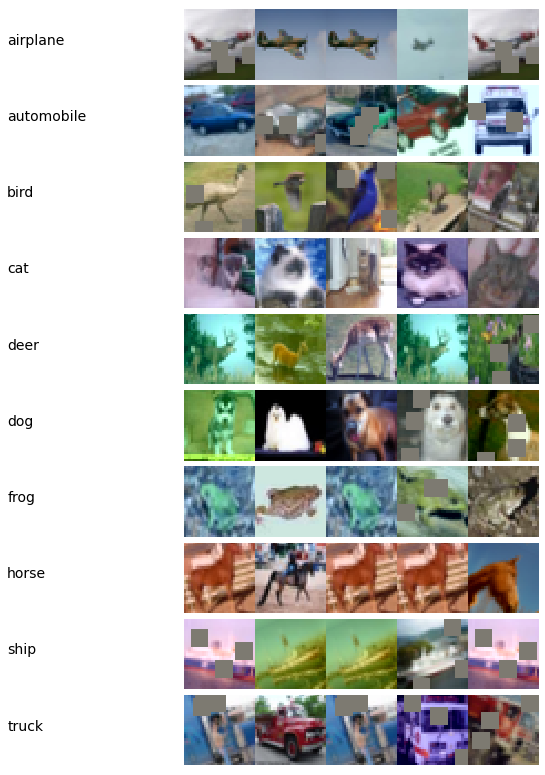

In [10]:
from __future__ import print_function
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [11]:
import eva4models
import torch
model = eva4models.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = "cuda"
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [12]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 20
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 1.247025).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0120, Accuracy: 44.83%; Test set: Average loss: 1.2470, Accuracy: 56.79%
Learning Rate = 0.052181


Validation loss decreased (1.247025 --> 0.904420).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0087, Accuracy: 61.36%; Test set: Average loss: 0.9044, Accuracy: 69.76%
Learning Rate = 0.140093


Epoch: 3, Train set: Average loss: 0.0071, Accuracy: 68.38%; Test set: Average loss: 0.9116, Accuracy: 70.08%
Learning Rate = 0.260161


Validation loss decreased (0.904420 --> 0.665612).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0061, Accuracy: 73.13%; Test set: Average loss: 0.6656, Accuracy: 77.48%
Learning Rate = 0.380186


Epoch: 5, Train set: Average loss: 0.0054, Accuracy: 76.17%; Test set: Average loss: 0.6756, Accuracy: 78.19%
Learning Rate = 0.467980


Validation loss decreased (0.665612 --> 0.621894).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0048, Accuracy: 78.69%; Test set: Average loss: 0.6219, Accuracy: 80.06%
Learning Rate = 0.500000


Validation loss decreased (0.621894 --> 0.547046).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0043, Accuracy: 80.77%; Test set: Average loss: 0.5470, Accuracy: 80.77%
Learning Rate = 0.493700


Validation loss decreased (0.547046 --> 0.464771).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0040, Accuracy: 82.56%; Test set: Average loss: 0.4648, Accuracy: 84.62%
Learning Rate = 0.475180


Validation loss decreased (0.464771 --> 0.463084).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0037, Accuracy: 83.67%; Test set: Average loss: 0.4631, Accuracy: 85.18%
Learning Rate = 0.445369


Validation loss decreased (0.463084 --> 0.398394).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0033, Accuracy: 85.25%; Test set: Average loss: 0.3984, Accuracy: 86.62%
Learning Rate = 0.405761


Validation loss decreased (0.398394 --> 0.382760).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0031, Accuracy: 86.49%; Test set: Average loss: 0.3828, Accuracy: 87.45%
Learning Rate = 0.358342


Validation loss decreased (0.382760 --> 0.382677).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0028, Accuracy: 87.69%; Test set: Average loss: 0.3827, Accuracy: 87.20%
Learning Rate = 0.305491


Validation loss decreased (0.382677 --> 0.357104).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0025, Accuracy: 88.69%; Test set: Average loss: 0.3571, Accuracy: 88.41%
Learning Rate = 0.249858


Validation loss decreased (0.357104 --> 0.348010).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0023, Accuracy: 89.57%; Test set: Average loss: 0.3480, Accuracy: 88.62%
Learning Rate = 0.194231


Validation loss decreased (0.348010 --> 0.308786).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0021, Accuracy: 90.79%; Test set: Average loss: 0.3088, Accuracy: 89.85%
Learning Rate = 0.141401


Validation loss decreased (0.308786 --> 0.292323).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0019, Accuracy: 91.64%; Test set: Average loss: 0.2923, Accuracy: 90.58%
Learning Rate = 0.094017


Validation loss decreased (0.292323 --> 0.282713).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0016, Accuracy: 92.87%; Test set: Average loss: 0.2827, Accuracy: 91.05%
Learning Rate = 0.054454


Validation loss decreased (0.282713 --> 0.274123).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0014, Accuracy: 93.78%; Test set: Average loss: 0.2741, Accuracy: 91.65%
Learning Rate = 0.024697


Validation loss decreased (0.274123 --> 0.269265).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0013, Accuracy: 94.46%; Test set: Average loss: 0.2693, Accuracy: 91.66%
Learning Rate = 0.006238


Validation loss decreased (0.269265 --> 0.268723).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0011, Accuracy: 94.96%; Test set: Average loss: 0.2687, Accuracy: 91.73%
Learning Rate = 0.000002



In [0]:
import cv2
import urllib
import numpy as np
from google.colab.patches import cv2_imshow

def getimage(img, transform, input_size=(32,32)):
  if img.startswith("http"):
      req = urllib.request.urlopen(img)
      arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
      img = cv2.imdecode(arr, -1) # 'Load it as it is'
  else:
    img = cv2.imread(img, 1)
  
  img = img[:,:, -1::-1]
  
  img = np.uint8(cv2.resize(img, input_size))

  return transform(img)

In [0]:
in_images = [
          (0, 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Egyptair.a330-200.su-gce.arp.jpg/1200px-Egyptair.a330-200.su-gce.arp.jpg'),
          (1, 'https://upload.wikimedia.org/wikipedia/commons/5/5b/Riley_4-68_Riviera_1961.jpg'),
          (2, 'https://upload.wikimedia.org/wikipedia/commons/4/45/Eopsaltria_australis_-_Mogo_Campground.jpg'),
          (3, 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/800px-Cat_November_2010-1a.jpg'),
          (4, 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Spotted_deer_in_S.V._zoo%2C_Tirupathi_%28May_2019%29.jpg/1920px-Spotted_deer_in_S.V._zoo%2C_Tirupathi_%28May_2019%29.jpg'),
          (5, 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/75/%22Boxer_dog%22_stand.jpg/1280px-%22Boxer_dog%22_stand.jpg'),
          (6, 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg/800px-Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg'),
          (7, 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Horseracing_Churchill_Downs.jpg/1920px-Horseracing_Churchill_Downs.jpg'),
          (8, 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Marina_%28ship%2C_2011%29%2C_S%C3%A8te_01.jpg/1920px-Marina_%28ship%2C_2011%29%2C_S%C3%A8te_01.jpg'),
          (9, 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Bergingstruck_%28tow_truck%29.jpg/1280px-Bergingstruck_%28tow_truck%29.jpg')
]
#
images = []
target_classes = []

for i in in_images:
  images.append(getimage(i[1], test_transforms))
  target_classes.append(i[0])

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


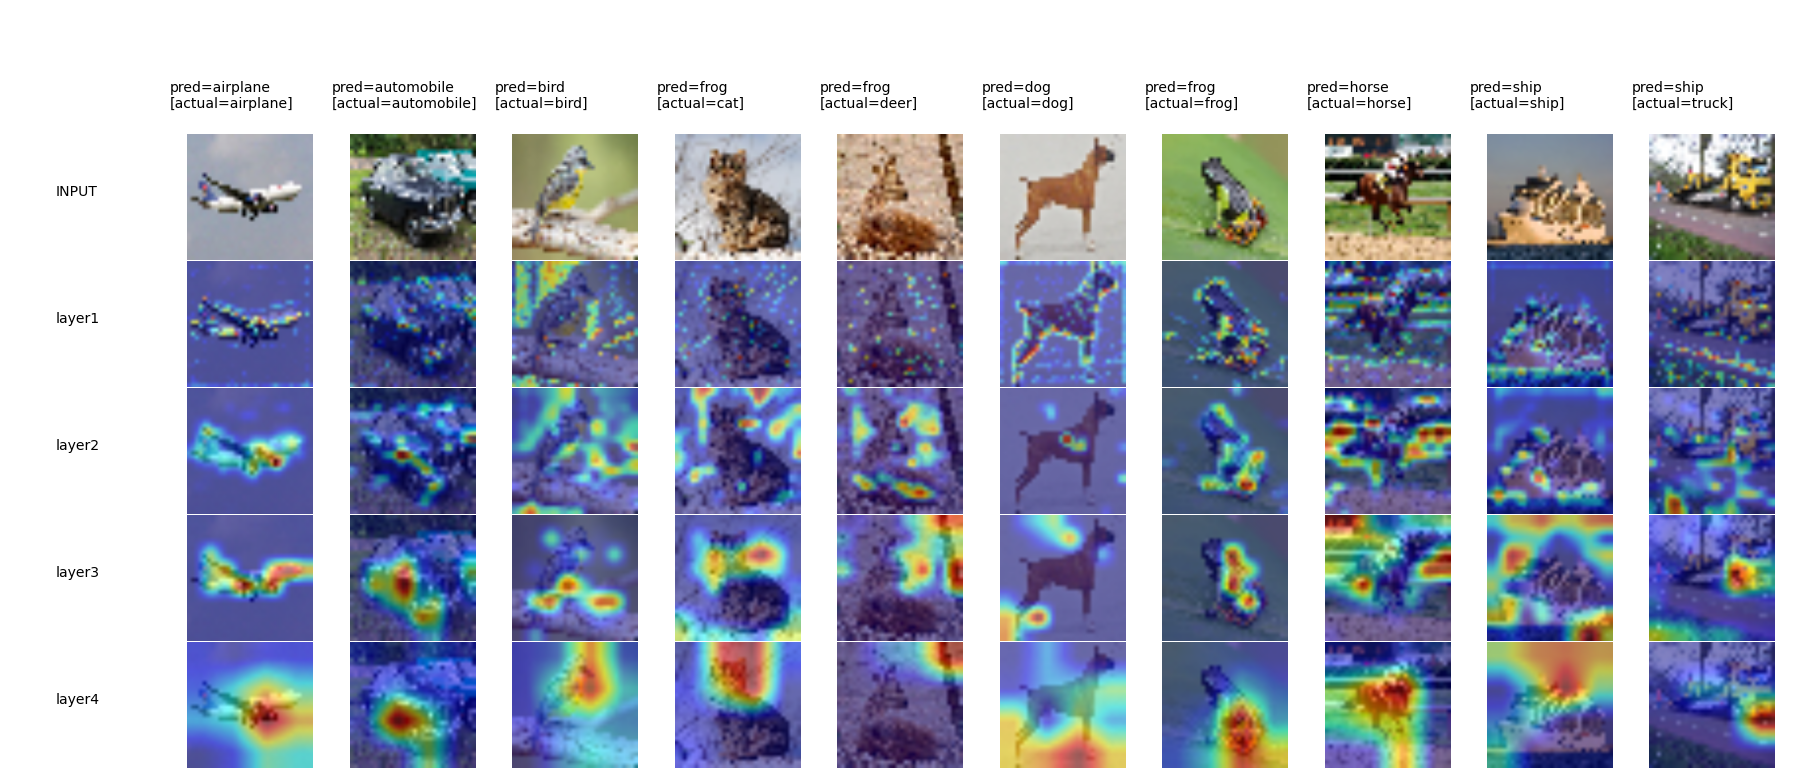

In [15]:
from eva4gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = GRADCAM(images, target_classes, model, target_layers)
PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)